K-Nearest Neighbors (KNN) Implementation

In [125]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
#from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestNeighbors


In [126]:
#Reading in the data
os.chdir(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\0_Datasets\1.7Master_Files\Individual Year Files_Take2")
df = pd.read_csv("merged_2023.csv")
distgrad = pd.read_csv(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\0_Datasets\1.6Data2023\District\clean_data\distgrad_2023_clean.csv")
distprof = pd.read_csv(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\0_Datasets\1.6Data2023\District\clean_data\distprof_2023_clean.csv")


# Step 1: Dropping Useless Columns. 
Columns are useless if: 
* Have 50% or more missing values 
* Are numerator / denominator values 
* Are charter schools 


In [127]:
clean_df = df[df['Charter School (Y/N)'] == 'N']
def calculate_missing_percentage(df):
    """
    Function to calculate the percentage of missing values in each column of a given dataset.
    
    Parameters:
        df (pd.DataFrame): The dataset as a pandas DataFrame.
    
    Returns:
        pd.Series: A Series with column names as index and percentage of missing values as values.
    """
    missing_percentage = (df.isna().sum() / len(df)) * 100
    missing_percentage = missing_percentage[missing_percentage > 0]  # Only keep columns with missing values
    
    return missing_percentage.sort_values(ascending=False)  # Sort in descending order
def drop_columns(df, threshold=50):
    """
    Function to drop columns with missing values exceeding a specified threshold
    and columns containing 'numerator' or 'denominator' in their names. These columsn are going to be fairly useless for analysis 
    
    Parameters:
        df (pd.DataFrame): The dataset as a pandas DataFrame.
        threshold (float): The percentage threshold for dropping columns.
    
    Returns:
        pd.DataFrame: The dataframe with columns dropped.
    """
    print(f"Original Dataset Shape: {df.shape}")
    missing_percentage = calculate_missing_percentage(df)
    cols_to_drop = set(missing_percentage[missing_percentage >= threshold].index)
    
    # Drop columns containing 'numerator' or 'denominator' (case-insensitive)
    cols_to_drop.update([col for col in df.columns if 'numerator' in col.lower() or 'denominator' in col.lower()])
    
    resulting_df = df.drop(columns=cols_to_drop)

    print(f"Dropped Dataset Shape: {resulting_df.shape}")
    return resulting_df

clean_df = drop_columns(clean_df)
clean_df.shape

Original Dataset Shape: (1021, 6553)
Dropped Dataset Shape: (1021, 2137)


(1021, 2137)

Text(0.5, 1.0, 'Histogram of percentage of NA values in columns')

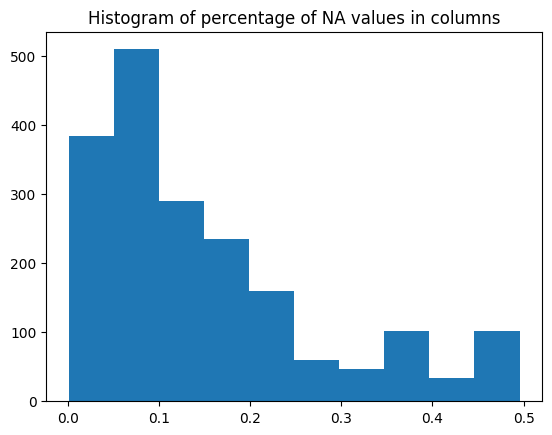

In [128]:
plt.hist(calculate_missing_percentage(clean_df) / 100)
plt.title("Histogram of percentage of NA values in columns")

Step1 Results: Data went from (1209, 6553) --> (1021, 2118)

# Step 2: Feature Engineering.
Finding relevant columns in DISTGRAD and DISTPROF and placing them into buckets

In [129]:
distgrad_clean = drop_columns(distgrad)
distprof_clean = drop_columns(distprof)

Original Dataset Shape: (1209, 950)
Dropped Dataset Shape: (1209, 277)
Original Dataset Shape: (1209, 426)
Dropped Dataset Shape: (1209, 416)


Bucketing DISTGRAD columns into sub-buckets 

In [130]:
district_identifiers = [
    "DISTRICT_id", "DISTRICT", "DISTNAME", "COUNTY", "CNTYNAME",
    "REGION", "DFLCHART", "DFLALTED"
]

#Bucketing relevant columns within the DISTGRAD dataset
race_ethnicity = [
    "District 2022 Attendance: Two or More Races Days Membership",
    "District 2022 Attendance: African American Days Membership",
    "District 2022 Attendance: Hispanic Days Membership",
    "District 2022 Attendance: White Days Membership"
]

economic_special_needs = [
    "District 2022 Attendance: Econ Disadv Days Membership",  # Economically Disadvantaged
    "District 2022 Attendance: Special Ed Days Membership",   # Special Education
    "District 2022 Attendance: EB/EL Days Membership",        # English Learners
    "District 2022 Attendance: At Risk Days Membership"       # At-Risk Students
]

gender_distribution = [
    "District 2022 Attendance: Female Days Membership",
    "District 2022 Attendance: Male Days Membership"
]


Bucketing DISTPROF columns into sub-buckets

In [131]:
### STUDENT DEMOGRAPHICS ###
grade_level_student_membership = [
    "District 2023 Student Membership: EE Count",
    "District 2023 Student Membership: PK Count",
    "District 2023 Student Membership: KG Count",
    "District 2023 Student Membership: 01 Count",
    "District 2023 Student Membership: 02 Count",
    "District 2023 Student Membership: 03 Count",
    "District 2023 Student Membership: 04 Count",
    "District 2023 Student Membership: 05 Count",
    "District 2023 Student Membership: 06 Count",
    "District 2023 Student Membership: 07 Count",
    "District 2023 Student Membership: 08 Count",
    "District 2023 Student Membership: 09 Count",
    "District 2023 Student Membership: 10 Count",
    "District 2023 Student Membership: 11 Count",
    "District 2023 Student Membership: 12 Count",
    "District 2023 Student Membership: All Students Count"
]

race_ethnicity = [
    "District 2023 Student Membership: American Indian Count",
    "District 2023 Student Membership: Asian Count",
    "District 2023 Student Membership: Pacific Islander Count",
    "District 2023 Student Membership: Two or More Races Count",
    "District 2023 Student Membership: African American Count",
    "District 2023 Student Membership: Hispanic Count",
    "District 2023 Student Membership: White Count"
]

economic_special_needs = [
    "District 2023 Student Membership: Special Ed Count",
    "District 2023 Student Membership: Bilingual/ESL Count",
    "District 2023 Student Membership: Gifted & Talented Count",
    "District 2023 Student Membership: EB/EL Count",
    "District 2023 Student Membership: Econ Disadv Count",
    "District 2023 Student Membership: Non-Educationally Disadv Count",
    "District 2023 Student Membership: At Risk Count",
    "District 2023 Student Membership: Dyslexia Count",
    "District 2023 Student Membership: Section 504 Count",
    "District 2023 Student Membership: Title I Count",
    "District 2023 Student Membership: Homeless Count",
    "District 2023 Student Membership: Immigrant Count",
    "District 2023 Student Membership: Migrant Count",
    "District 2023 Student Membership: Military-Connected Count",
    "District 2023 Student Membership: Foster Care Count"
]

gender_distribution = [
    "District 2023 Student Membership: Male Count",
    "District 2023 Student Membership: Female Count"
]

### Class Size & Teacher-Student Ratio ###
class_size_student_counts = [
    "District 2023 Class Size: Sec Soc Stud- # Students",
    "District 2023 Class Size: Sec Sci     - # Students",
    "District 2023 Class Size: Sec Math    - # Students",
    "District 2023 Class Size: Sec For Lng - # Students",
    "District 2023 Class Size: Sec English - # Students",
    "District 2023 Class Size: Grade 6     - # Students",
    "District 2023 Class Size: Grade 5     - # Students",
    "District 2023 Class Size: Grade 4     - # Students",
    "District 2023 Class Size: Grade 3     - # Students",
    "District 2023 Class Size: Grade 2     - # Students",
    "District 2023 Class Size: Grade 1     - # Students",
    "District 2023 Class Size: Mixed Elem. - # Students",
    "District 2023 Class Size: Kindergarten- # Students"
]

### Class Size & Teacher-Student Ratio ### 
average_class_size = [
    "District 2023 Class Size: Sec Soc Stud- Avg Size",
    "District 2023 Class Size: Sec Sci     - Avg Size",
    "District 2023 Class Size: Sec Math    - Avg Size",
    "District 2023 Class Size: Sec For Lng - Avg Size",
    "District 2023 Class Size: Sec English - Avg Size",
    "District 2023 Class Size: Grade 6     - Avg Size",
    "District 2023 Class Size: Grade 5     - Avg Size",
    "District 2023 Class Size: Grade 4     - Avg Size",
    "District 2023 Class Size: Grade 3     - Avg Size",
    "District 2023 Class Size: Grade 2     - Avg Size",
    "District 2023 Class Size: Grade 1     - Avg Size",
    "District 2023 Class Size: Kindergarten- Avg Size"
]


staff_counts = [
    "District 2023 Staff: Teacher Total Full Time Equiv Count",
    "District 2023 Staff: Support Total Full Time Equiv Count",
    "District 2023 Staff: School Admin Total Full Time Equiv Count",
    "District 2023 Staff: Central Admin Total Full Time Equiv Count",
    "District 2023 Staff: Educ Aide Total Full Time Equiv Count",
    "District 2023 Staff: Auxiliary Total Full Time Equiv Count",
    "District 2023 Staff: All Staff Total Full Time Equiv Count"
]


### Staff Demographics ### 
staff_counts = [
    "District 2023 Staff: Teacher Total Full Time Equiv Count",
    "District 2023 Staff: Support Total Full Time Equiv Count",
    "District 2023 Staff: School Admin Total Full Time Equiv Count",
    "District 2023 Staff: Central Admin Total Full Time Equiv Count",
    "District 2023 Staff: Educ Aide Total Full Time Equiv Count",
    "District 2023 Staff: Auxiliary Total Full Time Equiv Count",
    "District 2023 Staff: All Staff Total Full Time Equiv Count"
]

teacher_experience = [
    "District 2023 Staff: Teacher Beginning Full Time Equiv Count",
    "District 2023 Staff: Teacher 1-5 Years Full Time Equiv Count",
    "District 2023 Staff: Teacher 6-10 Years Full Time Equiv Count",
    "District 2023 Staff: Teacher 11-20 Years Full Time Equiv Count",
    "District 2023 Staff: Teacher 21-30 Years Full Time Equiv Count",
    "District 2023 Staff: Teacher > 30 Years Full Time Equiv Count"
]


staff_qualifications = [
    "District 2023 Staff: Teacher No Degree Full Time Equiv Count",
    "District 2023 Staff: Teacher BA Degree Full Time Equiv Count",
    "District 2023 Staff: Teacher MS Degree Full Time Equiv Count",
    "District 2023 Staff: Teacher PH Degree Full Time Equiv Count"
]

staff_race_ethnicity = [
    "District 2023 Staff: Teacher American Indian Full Time Equiv Count",
    "District 2023 Staff: Teacher Pacific Islander Full Time Equiv Count",
    "District 2023 Staff: Teacher Asian Full Time Equiv Count",
    "District 2023 Staff: Teacher African American Full Time Equiv Count",
    "District 2023 Staff: Teacher Hispanic Full Time Equiv Count",
    "District 2023 Staff: Teacher White Full Time Equiv Count",
    "District 2023 Staff: Teacher Two or more races Full Time Equiv Count"
]

staff_gender_distribution = [
    "District 2023 Staff: Teacher Male Full Time Equiv Count",
    "District 2023 Staff: Teacher Female Full Time Equiv Count"
]

Making overall big buckets

In [132]:
district_identifiers = [
    "DISTRICT_id", "DISTRICT", "DISTNAME", "COUNTY", "CNTYNAME",
    "REGION", "DFLCHART", "DFLALTED"
] + [
    "District",
    "District Number",
    "TEA District Type",
    "TEA Description",
    "NCES District Type",
    "NCES Description",
    "Charter School (Y/N)"
]



student_demographics = (
    grade_level_student_membership +
    race_ethnicity +
    economic_special_needs +
    gender_distribution + 
    race_ethnicity + 
    economic_special_needs + 
    gender_distribution
)

class_size_teacher_ratio = (
    class_size_student_counts +
    average_class_size
)

staff_demographics = (
    staff_counts +
    teacher_experience +
    staff_qualifications +
    staff_race_ethnicity +
    staff_gender_distribution
)


# Step 3: Data Modeling: 


In [133]:
merged_df = distgrad_clean.merge(distprof_clean, how = 'left', on = 'DISTRICT_id')

In [141]:
# Step 1: Select relevant feature buckets
selected_columns = student_demographics + class_size_teacher_ratio + staff_demographics

# Step 2: Filter dataset for selected features
#Get the intersection of selected_columns and existing columns in merged_df
existing_columns = [col for col in selected_columns if col in merged_df.columns]

# Select only available columns
knn_df = merged_df[["DISTRICT_id"] + existing_columns].copy()


# Step 3: Handle missing values (e.g., fill with median)
imputer = SimpleImputer(strategy="median")  # Change to 'mean' or 'most_frequent' if preferred
knn_df[selected_columns] = imputer.fit_transform(knn_df[selected_columns])

# Step 4: Normalize the feature set
scaler = StandardScaler()
knn_df[selected_columns] = scaler.fit_transform(knn_df[selected_columns])

# Step 5: Fit KNN model (excluding DISTRICT_id)
knn_model = NearestNeighbors(n_neighbors=5, metric="euclidean")  # Adjust neighbors as needed
knn_model.fit(knn_df[selected_columns])

# Step 6: Find the nearest neighbors for DISTRICT_id = 1902
query_point = knn_df[knn_df["DISTRICT_id"] == r"'001902"][selected_columns]
distances, indices = knn_model.kneighbors(query_point)

# Step 7: Get the closest districts
nearest_districts = clean_df.iloc[indices[0]]["DISTRICT_id"]

print("Top 5 closest districts to 1902:", nearest_districts.tolist())

Top 5 closest districts to 1902: [1902, 237904, 246908, 193902, 220907]


In [144]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import pandas as pd

def find_nearest_districts(merged_df, district_id, feature_buckets, n_neighbors=5, impute_strategy="median"):
    """
    Finds the nearest neighboring districts using K-Nearest Neighbors (KNN).
    
    Parameters:
        merged_df (pd.DataFrame): The dataset containing district data.
        district_id (str or int): The ID of the district to find neighbors for.
        feature_buckets (list): List of feature columns to include in KNN.
        n_neighbors (int): Number of nearest neighbors to find (default=5).
        impute_strategy (str): Strategy for imputing missing values (default="median").
    
    Returns:
        list: IDs of the nearest districts.
    """
    # Step 1: Filter dataset for selected features
    existing_columns = [col for col in feature_buckets if col in merged_df.columns]
    
    # Select only available columns
    knn_df = merged_df[["DISTRICT_id"] + existing_columns].copy()
    
    # Step 2: Handle missing values
    imputer = SimpleImputer(strategy=impute_strategy)
    knn_df[existing_columns] = imputer.fit_transform(knn_df[existing_columns])
    
    # Step 3: Normalize the feature set
    scaler = StandardScaler()
    knn_df[existing_columns] = scaler.fit_transform(knn_df[existing_columns])
    
    # Step 4: Fit KNN model (excluding DISTRICT_id)
    knn_model = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean")
    knn_model.fit(knn_df[existing_columns])
    
    # Step 5: Find the nearest neighbors for the specified district
    query_point = knn_df[knn_df["DISTRICT_id"] == district_id][existing_columns]
    if query_point.empty:
        raise ValueError(f"District ID {district_id} not found in dataset.")
    
    distances, indices = knn_model.kneighbors(query_point)
    
    # Step 6: Get the closest districts
    nearest_districts = knn_df.iloc[indices[0]] ["DISTRICT_id"].tolist()
    
    return nearest_districts

# Example usage:
selected_features = student_demographics + class_size_teacher_ratio + staff_demographics
closest_districts = find_nearest_districts(merged_df, "'001902", selected_features)
print("Top 5 closest districts:", closest_districts)


Top 5 closest districts: ["'001902", "'196902", "'206901", "'161802", "'177905"]


In [140]:
print(knn_df["DISTRICT_id"])
knn_df[knn_df["DISTRICT_id"] == r"'001902"]

0       '001902
1       '001903
2       '001904
3       '001906
4       '001907
         ...   
1204    '252902
1205    '252903
1206    '253901
1207    '254901
1208    '254902
Name: DISTRICT_id, Length: 1209, dtype: object


,DISTRICT_id,District 2023 Student Membership: EE Count,District 2023 Student Membership: PK Count,District 2023 Student Membership: KG Count,District 2023 Student Membership: 01 Count,District 2023 Student Membership: 02 Count,District 2023 Student Membership: 03 Count,District 2023 Student Membership: 04 Count,District 2023 Student Membership: 05 Count,District 2023 Student Membership: 06 Count,...,District 2023 Staff: Teacher PH Degree Full Time Equiv Count,District 2023 Staff: Teacher American Indian Full Time Equiv Count,District 2023 Staff: Teacher Pacific Islander Full Time Equiv Count,District 2023 Staff: Teacher Asian Full Time Equiv Count,District 2023 Staff: Teacher African American Full Time Equiv Count,District 2023 Staff: Teacher Hispanic Full Time Equiv Count,District 2023 Staff: Teacher White Full Time Equiv Count,District 2023 Staff: Teacher Two or more races Full Time Equiv Count,District 2023 Staff: Teacher Male Full Time Equiv Count,District 2023 Staff: Teacher Female Full Time Equiv Count
0,'001902,-0.273578,-0.279972,-0.308074,-0.307756,-0.315305,-0.323612,-0.315804,-0.319875,-0.317784,...,-0.264266,-0.310498,-0.17375,-0.195032,-0.180382,-0.284736,-0.303407,-0.288946,-0.310671,-0.320665


# Archive Code Used for Troubleshooting

In [ ]:
all_columns = list(merged_df.columns)
missing_col1 = set(class_size_teacher_ratio) - set(all_columns)

print("Total Columns Missing from merged dataset")
print(len(list(missing_col1)))

print("Total Columns coming from class_size_student_counts list")
print(len(list(set(class_size_student_counts)- set(all_columns))))

print("Total Columns coming from average_class_size list")
print(len(list(set(average_class_size) - set(all_columns))))


print("How many missing columns exist in distgrad? ")
print(len(list(set(missing_col1) - set(list(distgrad_clean.columns)))))

print("How many missing columns exist in distprof?")
print(len(list(set(missing_col1) - set(list(distprof_clean.columns)))))

#Conclusion: These 18 columns that are not being recognized come from both distgrad and distprof, when merging there must be some funky business 
print(missing_col1)


print((list(set(average_class_size) - set(all_columns))))
search_term = 'District 2023 Class Size: Sec Math'

real_val = [col for col in merged_df.columns if search_term in col]
print(real_val)